# Instantiate BERT model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 22 21:56:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |    633MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# BERT reference: https://www.kaggle.com/models/tensorflow/bert
!pip install tensorflow_hub tensorflow_text
!pip install keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [ ]:
# Instatiate bert preprocessor
bert_preprocessor = hub.KerasLayer(preprocess_url)

# Preprocess the Text

In [ ]:
# Create text
test_text = ['For our children we need to make sure we have “a planet that is still hospitable in 25 years”', 'Let’s face it. There’s no PLANET B!']

# Preprocess the text
preprocessed_text = bert_preprocessor(test_text)

# Keys returned from the preprocessed text
print(preprocessed_text.keys())

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])


In [ ]:
# Shows the word ids for each word
print(preprocessed_text['input_word_ids'])

tf.Tensor(
[[  101  2005  2256  2336  2057  2342  2000  2191  2469  2057  2031  1523
   1037  4774  2008  2003  2145  7570 13102  6590  3468  1999  2423  2086
   1524   102     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  101  2292  1521  1055  2227  2009  1012  2045  1521  1055  2053  4774
   1038   999   102     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0 

# Convert the text into its word embeddings

In [ ]:
# Instatiate the Bert encoder to get the word embeddings
bert_model = hub.KerasLayer(encoder_url)

# Get the word embeddings from text defined earlier
word_embeddings = bert_model(preprocessed_text)

# View the word embeddings' keys
print(word_embeddings.keys())

dict_keys(['sequence_output', 'encoder_outputs', 'pooled_output', 'default'])


In [ ]:
# Show the embeddings for both scentences in the text
word_embeddings['pooled_output']

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.7947769 , -0.33802423, -0.41778976, ...,  0.00584935,
        -0.63994205,  0.73869354],
       [-0.86193836, -0.47920293, -0.92479664, ..., -0.80340797,
        -0.72885835,  0.9210373 ]], dtype=float32)>

# Now that the sentences have been coverted to embeddings, it can be used in a neural network for different applications



Once we Have our political sentiment data, we can recreate the steps below in order to train our model.

For now, I tested it on a dataset for spam emails. This will be a simple neural network with a final softmax layer and an output of 2 for binary classification. When we are working with our political sentiment analysis data, we would need more (left leaning, right leaning, etc..)

# Process Data

In [ ]:
# Read in file
data = pd.read_csv('/content/drive/MyDrive/ExtractedTweets.csv', encoding='latin1')

# Show some data
data.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


<Axes: >

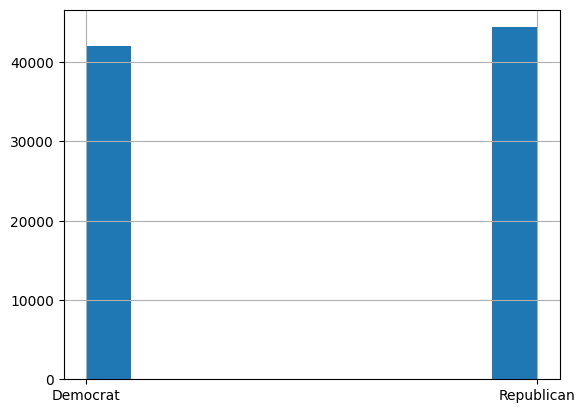

In [ ]:
# Show data Imbalance
data['Party'].hist()

In [ ]:
# Seperate only spam data
data_spam = data[data['Party'] == 'Democrat']
data_spam.shape

(42068, 2)

In [ ]:
# Seperate only non-spam data
data_ham = data[data['Party'] == 'Republican']
data_ham.shape

(44392, 3)

In [ ]:
# Down sample non-spam data to avoid overfitting
data_ham_downsampled = data_ham.sample(data_spam.shape[0])
data_ham_downsampled.shape

(42068, 3)

In [ ]:
# Merge samples backtogether again
final_data = pd.concat([data_spam, data_ham_downsampled])
final_data.shape

(84136, 3)

Party
Democrat      42068
Republican    42068
Name: count, dtype: int64


<Axes: >

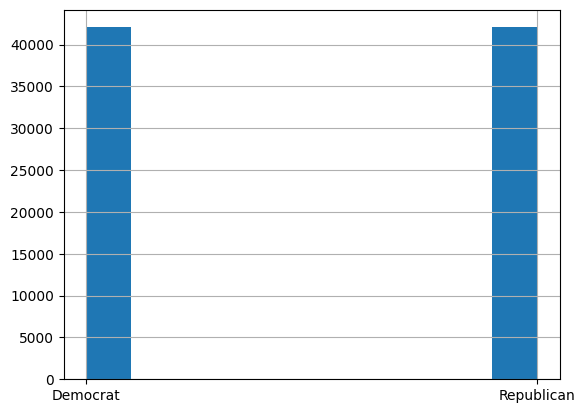

In [ ]:
# Check downsampled dataset
print(final_data['Party'].value_counts())
final_data['Party'].hist()

In [ ]:
print('Shape of final data: ' + str(final_data.shape))
final_data.sample(5)

Shape of final data: (84136, 3)


,Party,Handle,Tweet
20757,Democrat,RepZoeLofgren,The #IranDeal is the best option we have to pr...
71804,Republican,RepFredUpton,We wonât completely solve the problem of sch...
76093,Republican,PatrickMcHenry,Thanks to the #TaxCutsandJobsAct this #taxday ...
44344,Republican,RepPaulMitchell,"Great meeting with Adrian Schunk, Michigan Sta..."
16708,Democrat,daveloebsack,RT @EmilySkor: Congrats to our #BiofuelsSummit...


In [ ]:
# Convert spam and ham to 1s and 0s and store it in a new column named spam
final_data['Democrat'] = final_data['Party'].apply(lambda x: 1 if x=='Democrat' else 0)
final_data.sample(5)

# Get word embeddings for data

In [ ]:
# Make training and testing split with data

# Split the data into features (X) and target variable (y)
X = data['Tweet']
y = data['Party']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


In [ ]:
X_train.sample(10)

19508    RT @RepTedLieu: Rep. @louiseslaughterâs pass...
26644    RT @ESOPAssociation: Thanks to @NydiaVelazquez...
30765    RT @ABC: NEW: EPA violated federal law in spen...
39922    Thanks to all who came out to see Senator Merk...
44471    Today on Peace Officers Memorial Day we rememb...
67097    Marvin Quattlebaum is uniquely well qualified ...
86205    Great turnout at todayâs RPC meeting. Lookin...
660      RT @repjoecrowley: No one should have to choos...
7155     RT @davidcicilline: NEW: My letter with @RepDo...
70557    A tornado warning has been issued for Fort Ruc...
Name: Tweet, dtype: object

In [ ]:
# Defines a function to get the scentence embeddings for each entry
def get_sentence_embedding(sentences):
  # preprocess words
  preprocessed_text = bert_preprocessor(sentences)

  # get embedding vectors from the pooled_output key
  return bert_model(preprocessed_text)['pooled_output']

# Small scale driver to test function
get_sentence_embedding([
    "#FACT: 24 percent of Americans said they didn‚Äôt fill a prescription in the previous year because of the high cost.‚Ä¶ https://t.co/meU89Ikiqm",
    "Today we welcome a new vessel to the USCG fleet patrolling the NC coastline. The CG Cutter Richard Snyder will be t‚Ä¶ https://t.co/9RpMjIGkVh"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.80620706, -0.5964182 , -0.948337  , ..., -0.66721815,
        -0.73574716,  0.84141123],
       [-0.7408504 , -0.5604239 , -0.9202296 , ..., -0.67929494,
        -0.75683516,  0.763301  ]], dtype=float32)>

In [1]:
# Visualize getting embeddings for the entire training set
X_train_embeddings = get_sentence_embedding(X_train['Tweet'])

# Get embeddings for testing set
X_test_embeddings = get_sentence_embedding(X_test['Tweet'])


NameError: name 'get_sentence_embedding' is not defined

In [ ]:
# Before and after word embeddings
print('Before' + str(X_train.shape))
print('After' + str(X_train_embeddings.shape))

Before(64845,)


NameError: name 'X_train_embeddings' is not defined

In [ ]:
# Convert the y vectors for the softmax function
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

NameError: name 'to_categorical' is not defined

# Create Neural Network


In [ ]:
# Bert Layers for preprocessing and getting word embeddings
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocessor(text_input)
outputs = bert_model(preprocessed_text)

# Neural network layers
hiddenLayer = tf.keras.layers.Dense(50, name='hidden', activation='relu')(outputs['pooled_output'])
dropoutLayer = tf.keras.layers.Dropout(0.1, name='drouput')(hiddenLayer)
outputLayer = tf.keras.layers.Dense(2, activation='softmax', name='output') (dropoutLayer)

# Final model
model = tf.keras.Model(inputs=[text_input], outputs = [outputLayer])

In [ ]:
# Get the model's summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
# Compile the model
model.compile (
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

In [ ]:
# Start training
results = model.fit(
    X_train,
    y_train_one_hot,
    epochs = 11
)

Epoch 1/11
35/35 [==============================] - 9s 260ms/step - loss: 0.1339 - accuracy: 0.9571
Epoch 2/11
35/35 [==============================] - 9s 261ms/step - loss: 0.1340 - accuracy: 0.9554
Epoch 3/11
35/35 [==============================] - 9s 262ms/step - loss: 0.1173 - accuracy: 0.9625
Epoch 4/11
35/35 [==============================] - 9s 264ms/step - loss: 0.1141 - accuracy: 0.9661
Epoch 5/11
35/35 [==============================] - 9s 266ms/step - loss: 0.1210 - accuracy: 0.9634
Epoch 6/11
35/35 [==============================] - 9s 269ms/step - loss: 0.1097 - accuracy: 0.9679
Epoch 7/11
35/35 [==============================] - 9s 265ms/step - loss: 0.1102 - accuracy: 0.9661
Epoch 8/11
35/35 [==============================] - 9s 267ms/step - loss: 0.1039 - accuracy: 0.9688
Epoch 9/11
35/35 [==============================] - 9s 268ms/step - loss: 0.1026 - accuracy: 0.9688
Epoch 10/11
35/35 [==============================] - 9s 267ms/step - loss: 0.1110 - accuracy: 0.9670

In [ ]:
print('Accuracy on Testing Set:')
model.evaluate(X_test, y_test_one_hot)

Accuracy on Testing Set:
12/12 [==============================] - 4s 255ms/step - loss: 0.0812 - accuracy: 0.9813


[0.08120762556791306, 0.98128342628479]

# Results

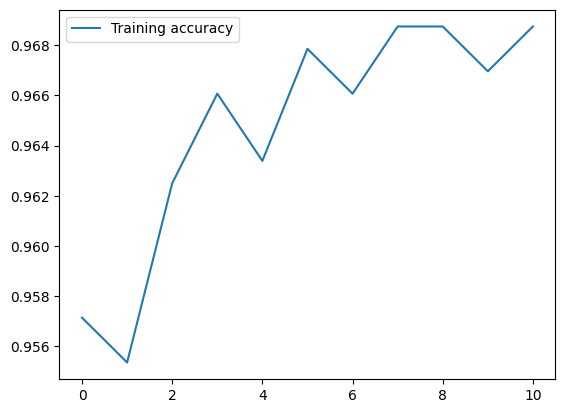

In [ ]:
# Plot Accuracy
plt.plot(results.history['accuracy'], label='Training accuracy')
plt.legend()

In [ ]:
import numpy as np

# Sample predictions from a softmax output
y_predicted = model.predict(X_test)  # Softmax predictions

# Get the predicted class by finding the index of the maximum value along axis 1 (per row)
y_predicted_classes = np.argmax(y_predicted, axis=1)  # Resulting in class labels

# Check the predicted class labels
print("Predicted classes:", y_predicted_classes)

12/12 [==============================] - 4s 276ms/step
Predicted classes: [0 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0
 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0
 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0
 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1
 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1
 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0
 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0
 1 1 0 0]


In [ ]:
X_test.head()

,v2
4624,I'm on the bus. Love you
114,"Wa, ur openin sentence very formal... Anyway, ..."
5010,You have WON a guaranteed å£1000 cash or a å£2...
1852,This is the 2nd time we have tried 2 contact u...
3568,She's fine. Sends her greetings


In [ ]:
# Loop through the first 20 samples
for i in range(20):
    sample_text = X_test.iloc[i]['v2'] # The original text for the sample
    prediction = y_predicted_classes[i]  # The predicted output (0 or 1)

    # Convert the prediction to a human-readable label
    if prediction == 0:
        label = "Not spam"
    elif prediction == 1:
        label = "Spam"

    # Display the sample text and its predicted output
    print(f"Sample {i+1}: '{sample_text}'")
    print(f"Prediction: {label} \n")


Sample 1: 'I'm on the bus. Love you'
Prediction: Not spam 

Sample 2: 'Wa, ur openin sentence very formal... Anyway, i'm fine too, juz tt i'm eatin too much n puttin on weight...Haha... So anythin special happened?'
Prediction: Not spam 

Sample 3: 'You have WON a guaranteed å£1000 cash or a å£2000 prize. To claim yr prize call our customer service representative on 08714712412 between 10am-7pm Cost 10p'
Prediction: Spam 

Sample 4: 'This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate '
Prediction: Spam 

Sample 5: 'She's fine. Sends her greetings'
Prediction: Not spam 

Sample 6: 'Do you want a new Video phone? 600 anytime any network mins 400 Inclusive Video calls AND downloads 5 per week Free delTOMORROW call 08002888812 or reply NOW'
Prediction: Spam 

Sample 7: 'Do you want a new video handset? 750 anytime any network mins? Half Price Line Rental? Camcorder? Reply or call 08000930

Confusion Matrix:
[[184   3]
 [  4 183]]


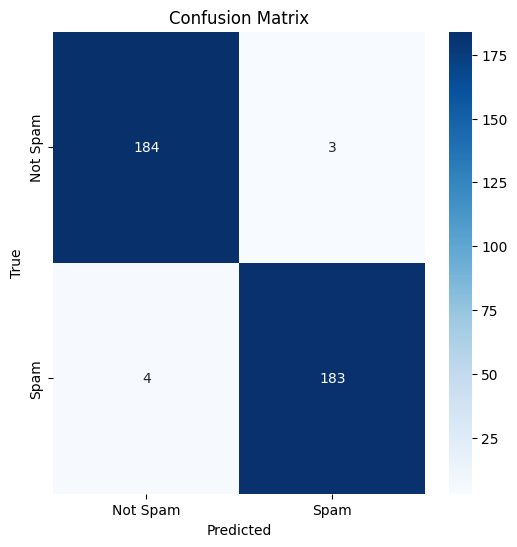

In [ ]:
# Assuming softmax predictions from the model
y_predicted_classes = np.argmax(y_predicted, axis=1)  # Convert softmax predictions to class labels

# Converting one-hot labels to class labels
y_test_classes = np.argmax(y_test_one_hot, axis=1)  # From one-hot to class labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_predicted_classes)  # True vs. predicted classes

# Print the confusion matrix to see the raw data
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for the game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your book."
]
# Will return softmax output, prediction is whatever index is higher
model.predict(reviews)

1/1 [==============================] - 0s 61ms/step


array([[0.04017913, 0.95982087],
       [0.00373652, 0.99626344],
       [0.13287874, 0.8671212 ],
       [0.9613589 , 0.03864108],
       [0.9815014 , 0.01849861]], dtype=float32)